### Importing
<b>
Importing the data and pre-processing it. Converting required columns to categorical(one-hot encoding) and Representing some entries in binary

In [28]:
# Get the data
df = pd.read_csv('data/compas.csv')
X_temp = df.drop(['race','score_text','c_charge_desc','two_year_recid'],axis=1)
X_temp['c_charge_degree'] = X_temp['c_charge_degree'].replace(['M','F'],[1,0])
x_race = pd.get_dummies(df['race'])
X = pd.concat([X_temp,x_race],axis=1)
y = df['two_year_recid']
#Splitting the races
aa_df = df[df['race'] == 'African-American']
cc_df = df[df['race'] == 'Caucasian']
print(X.shape,X_temp.shape,x_race.shape)
print(aa_df.shape,cc_df.shape)
X.head()

(5554, 25) (5554, 19) (5554, 6)
(2857, 23) (1892, 23)


,age,c_charge_degree,sex,priors_count,juv_fel_count,juv_misd_count,juv_other_count,decile_score,length_of_stay,priors_1,...,charge_any_drug,charge_any_violence_aggression,charge_any_theft,length_of_stay_thresh,African-American,Asian,Caucasian,Hispanic,Native American,Other
0,50,1,0,30,0,0,0,6,4,0,...,0,0,0,4,0,0,1,0,0,0
1,28,1,1,0,0,0,0,7,0,0,...,0,0,0,0,1,0,0,0,0,0
2,24,0,1,1,0,0,0,4,5,1,...,0,1,0,5,0,0,0,0,0,1
3,25,0,0,14,0,1,2,6,1,0,...,0,0,1,1,0,0,0,1,0,0
4,34,0,1,7,0,0,0,6,0,0,...,1,0,0,0,1,0,0,0,0,0


### Split
<b>Splitting the data into train and test sets, but doing so in a stratified manner so as to maintain the racial distribution in each set.

In [29]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,stratify=X[['African-American','Caucasian']],random_state=1)
mmscl = MinMaxScaler()
X_train_norm = mmscl.fit_transform(X_train)
X_test_norm = mmscl.transform(X_test)
X_train = pd.DataFrame(X_train, index=X_train.index, columns=X_train.columns)
X_test = pd.DataFrame(X_test, index=X_test.index, columns=X_test.columns)

<b>Why is processing the categorical predictors important? What is the risk of processing categorical predictors after splitting into train and validation sets?

**Ans) Categorical predictors need to be converted to a form in which they can be fed to the ML model. So 'Yes' and 'No' will not be understood by the model and hence need to be converted to '1' and '0'. Processing categorical predictors after splitting involves a risk as in one of the splits there is a chance of missing out on one of the predictors, which will hence not get converted to a digit in that split but be present in the other split, hence introducing an error in the model. In questions such as ours where we need to maintain race distribution in each split, we need to know about the distribution of races in the first place and hence need to process the predictor before splitting.**

### Exploratory Data Analysis
<b>
Make overlapping distributions (histograms) of the following predictors for two groups, African American & Caucasian.
- Age
- Priors count
- Sex
- Length of stay


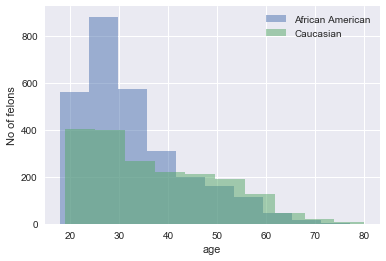

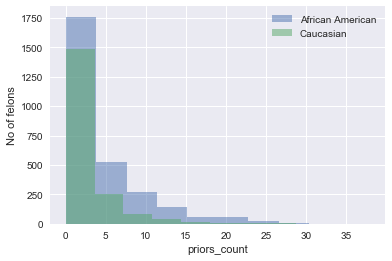

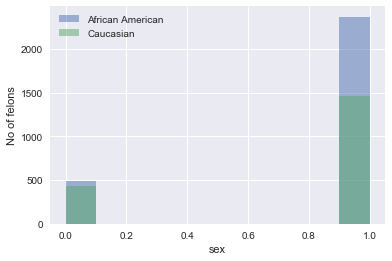

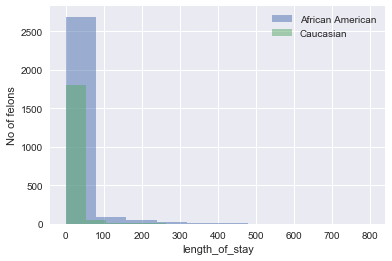

In [30]:
def myplot(label):
    plt.figure()
    plt.hist(X[label][X['African-American'] == 1],alpha=0.5,label='African American')
    plt.hist(X[label][X['Caucasian'] == 1],alpha=0.5,label='Caucasian')
    plt.xlabel('{}'.format(label))
    plt.ylabel('No of felons')
    plt.legend()
labels = ['age','priors_count','sex','length_of_stay']
for label in labels:
    myplot(label)
plt.show()

<b> 
Among the following variables, which ones show disparity between the two groups? Explain your results in 2-3 sentences.

**Ans) Agewise African American show a disparity by having steep numbers in the 25-30 and 30-35 age ranges. There are more priors_count for African Americans but the difference in number of Caucasians and African americans with the same no. of prios count is almost same. One sex for African American race is very dominant over the same Caucasian sex. No. of African Americans with length of stay less than 100 is much more than Caucasians **

### Prediction with 'Race'
<b> 
Build a logistic regression model to predict recidivism (two_year_recid) on these data and race has been included in the list of predictors.

In [31]:
model = LogisticRegression(C=100000)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
acc = accuracy_score(y_test,y_pred)
print('Overall model accuracy is : ',acc)
y_test_AA_base = y_test[X_test['African-American']==1]
y_test_CC_base = y_test[X_test['Caucasian']==1]
y_pred_AA_base = y_pred[X_test['African-American']==1]
y_pred_CC_base = y_pred[X_test['Caucasian']==1]
TN_AA_base,FP_AA_base,FN_AA_base,TP_AA_base = metrics.confusion_matrix(y_test_AA_base,y_pred_AA_base).ravel()
TN_CC_base,FP_CC_base,FN_CC_base,TP_CC_base = metrics.confusion_matrix(y_test_CC_base,y_pred_CC_base).ravel()
print('FPR for Arican American is ',100 * FP_AA_base/(FP_AA_base+TN_AA_base),'and for Caucasian is ',100 * FP_CC_base/(FP_CC_base+TN_CC_base))
print('FNR for Arican American is ',100 * FN_AA_base/(TP_AA_base+FN_AA_base),'and for Caucasian is ',100 * FN_CC_base/(TP_CC_base+FN_CC_base))
print('Ratio of FPR African American : FPR Caucasian is ',(FP_AA_base/(FP_AA_base+TN_AA_base))/(FP_CC_base/(FP_CC_base+TN_CC_base)))
print('Ratio of FNR African American : FNR Caucasian is ',(FN_AA_base/(TP_AA_base+FN_AA_base))/(FN_CC_base/(TP_CC_base+FN_CC_base)))

Overall model accuracy is :  0.6867686768676867
FPR for Arican American is  34.87544483985765 and for Caucasian is  10.619469026548673
FNR for Arican American is  28.8659793814433 and for Caucasian is  59.21052631578947
Ratio of FPR African American : FPR Caucasian is  3.2841043890865955
Ratio of FNR African American : FNR Caucasian is  0.4875143184421535


C:\Users\Joy Parikh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


<b>
Any disparity in the $FPR$ and $FNR$ for the two groups?

**Ans)African Anericans have a relatively high False Positive rate as compared to Caucasians, and Caucasians have a relatively high False Negative Rate wrt African Americans. This shows that there is a bias towawrds Caucasians as the model allows more Caucasians to be declared not risky falsely and more African Americans to be considered high-risk falsely.**

## Solutions

### Prediction without Race
<b>
Refit the logistic model earlier but this time without race as a predictor. 

In [32]:
X_train_raceless = X_train.drop(['African-American','Asian','Caucasian','Hispanic','Native American','Other'],axis=1)
X_test_raceless = X_test.drop(['African-American','Asian','Caucasian','Hispanic','Native American','Other'],axis=1)
X_train_raceless.head()

,age,c_charge_degree,sex,priors_count,juv_fel_count,juv_misd_count,juv_other_count,decile_score,length_of_stay,priors_1,priors_234,priors_5plus,juv_fel_1plus,juv_misd_1plus,juv_other_1plus,charge_any_drug,charge_any_violence_aggression,charge_any_theft,length_of_stay_thresh
5529,23,0,1,0,0,0,0,2,1,0,0,0,0,0,0,0,0,0,1
2765,76,0,1,0,0,0,0,1,2,0,0,0,0,0,0,0,1,0,2
5208,25,1,0,0,0,0,0,3,1,0,0,0,0,0,0,0,1,0,1
4086,56,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
57,26,0,1,0,0,0,0,3,2,0,0,0,0,0,0,0,0,0,2


In [33]:
X_train_raceless = X_train.drop(['African-American','Asian','Caucasian','Hispanic','Native American','Other'],axis=1)
X_test_raceless = X_test.drop(['African-American','Asian','Caucasian','Hispanic','Native American','Other'],axis=1)
model = LogisticRegression(C=100000)
model.fit(X_train_raceless,y_train)
y_pred = model.predict(X_test_raceless)
acc = accuracy_score(y_test,y_pred)
print('Overall model accuracy is : ',acc)
y_test_AA_race = y_test[X_test['African-American']==1]
y_test_CC_race = y_test[X_test['Caucasian']==1]
y_pred_AA_race = y_pred[X_test['African-American']==1]
y_pred_CC_race = y_pred[X_test['Caucasian']==1]
TN_AA_race,FP_AA_race,FN_AA_race,TP_AA_race = metrics.confusion_matrix(y_test_AA_race,y_pred_AA_race).ravel()
TN_CC_race,FP_CC_race,FN_CC_race,TP_CC_race = metrics.confusion_matrix(y_test_CC_race,y_pred_CC_race).ravel()
print('FPR for Arican American is ',100 * FP_AA_race/(FP_AA_race+TN_AA_race),'and for Caucasian is ',100 * FP_CC_race/(FP_CC_race+TN_CC_race))
print('FNR for Arican American is ',100 * FN_AA_race/(TP_AA_race+FN_AA_race),'and for Caucasian is ',100 * FN_CC_race/(TP_CC_race+FN_CC_race))
print('Ratio of FPR African American : FPR Caucasian is ',(FP_AA_race/(FP_AA_race+TN_AA_race))/(FP_CC_race/(FP_CC_race+TN_CC_race)))
print('Ratio of FNR African American : FNR Caucasian is ',(FN_AA_race/(TP_AA_race+FN_AA_race))/(FN_CC_race/(TP_CC_race+FN_CC_race)))

Overall model accuracy is :  0.6921692169216922
FPR for Arican American is  34.163701067615655 and for Caucasian is  10.619469026548673
FNR for Arican American is  29.209621993127147 and for Caucasian is  57.89473684210526
Ratio of FPR African American : FPR Caucasian is  3.217081850533808
Ratio of FNR African American : FNR Caucasian is  0.5045298344267416


C:\Users\Joy Parikh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


<b>
Now, without the race as a predictor, what do you observe?

**Ans) The Accuracy dropped a little when race was not included. The disparity between FPR for African American and Caucasian reduced by a little but the bias still exists. The disparity between FNR for African American and Caucasian reduced by a little but the bias still exists.**

<b>Compared to the model when the race is included as a predictor?

**Ans) When the race was included FPR(AA)=29.77 FPR(CC)=16.11 FNR(AA)=27.42 and FNR(CC)=47.79 . Without race as a predictor FPR(AA)=29.77 FPR(CC)=16.12 FNR(AA)=27.42 and FNR(CC)=50**

<b>Final Connclusion


**No a predictive tool should not be trusted even if it does not explicitly use a variable such as race. We can see from the results above that dropping race as a predictor did not affect the values by much and there is still a bias for Caucasian over African American race. The tool is being used to predict future crime and having a racial bias in such a tool is not the right thing to have. The bias is still occuring as many predictors other than the race predictor also have some sort of a racial bias in them which gets reflected on the model. For example the African American people had a larger priors_count than Caucasian and hence even though we are not using race as a predictor explicitly, other predictors with such racial bias which is impossible to remove will introduce a bias in the results of the model**

## Solutions

### ROC to look at big picture
<b>
Use logistic regression & plot the Receiver Operating Characteristic curve for two races, African Americans & Caucasians.

C:\Users\Joy Parikh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\Joy Parikh\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#lo

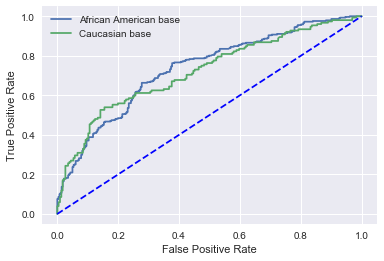

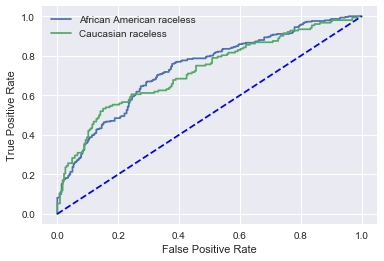

In [34]:
y_score_base = model.fit(X_train,y_train).decision_function(X_test)
y_score_AA_base = y_score_base[X_test['African-American']==1]
y_score_CC_base = y_score_base[X_test['Caucasian']==1]
tpr_base_AA,fpr_base_AA,_ = metrics.roc_curve(y_test_AA_base,y_score_AA_base)
tpr_base_CC,fpr_base_CC,_ = metrics.roc_curve(y_test_CC_base,y_score_CC_base)
y_score_race = model.fit(X_train_raceless,y_train).decision_function(X_test_raceless)
y_score_AA_race = y_score_race[X_test['African-American']==1]
y_score_CC_race = y_score_race[X_test['Caucasian']==1]
tpr_race_AA,fpr_race_AA,_ = metrics.roc_curve(y_test_AA_race,y_score_AA_race)
tpr_race_CC,fpr_race_CC,_ = metrics.roc_curve(y_test_CC_race,y_score_CC_race)
plt.figure()
plt.plot(tpr_base_AA,fpr_base_AA,label='African American base')
plt.plot(tpr_base_CC,fpr_base_CC,label='Caucasian base')
plt.plot([0,1],[0,1],color='blue',linestyle='dashed')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC with race')
plt.legend()
plt.figure()
plt.plot(tpr_race_AA,fpr_race_AA,label='African American raceless')
plt.plot(tpr_race_CC,fpr_race_CC,label='Caucasian raceless')
plt.plot([0,1],[0,1],color='blue',linestyle='dashed')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC without race')
plt.legend()
plt.show()

### So...
<b>
How to ensure the model is accuracte and unbiased?

**A major role in introducing racial bias can be handled by managing data and our algorithm.**

**1)The dataset which we are using to predict the results should be carefully chosen and it should make sure that it has no implicit bias in it. We should first of all ensure that the data is not very noisy and there is no chance that the model fitting on statistical noise may end up having a bias introduced into it. Human Bias is often reflected on dataset which is in turn reflected on the results of the ML model and hence the removal of any such biases should be ensured.**

**2)Misrepresentation of one of the category of the predictor can introduce a bias against it. For example in the racial bias case, the number of data points for people of African American race was much more than the number of data points for Caucasian people. Hence there is a chance that the Caucasian race did not have an exhaustive representation in the dataset as compared to African American race, which causes the introduction of bias. Hence a proper representation of all races should be ensured.**

**3)The training we perform only aims at improving our loss function. The loss function currently focuses only on the correctness of classification and does not consider punishing biases. We can introduce a term into the loss function which is used to punish bias, similar to how we introduce a term to punish blown up betas in regularisation.** 

<div class="alert alert-block alert-danger" style="color:black;background-color:#EFF8D0">
<h2 style="color:black;background-color:#EFF8D0"> Come up with a better model
</h2>  
    
Improving the models used previously by including:
 - Polynomial terms
 - Interaction terms
 - Regularization parameters
 - Different upsampling techniques
 - KNN classification

with a goal to maximize the new metric which includes both the bias and the accuracy, we define `Bias_Corrected_Accuracy(BCA)` as:
    

$$BCA = Acccuracy - {\left|FPR(AA) - FPR(CC)\right|}$$



<br> **Get the data again and make it suitable for upsampling(to balance the racial bias in number of data points)**

In [35]:
from sklearn.utils import shuffle
aa_df = df[df['race'] == 'African-American']
cc_df = df[df['race'] == 'Caucasian']

n_aa = len(aa_df)
n_cc = len(cc_df)
df = pd.concat([aa_df, cc_df])
df = shuffle(df)
df['race'] = df['race'].replace(to_replace = ['African-American', 'Caucasian'], value = [0, 1])
df['c_charge_degree'] = df['c_charge_degree'].replace(to_replace = ['M', 'F'], value = [1, 0])

X = df.drop(['score_text', 'c_charge_desc', 'race'], axis=1)
y_temp = df['race']
#print(y_temp)

<br> **Using the SMOTE Method for upsampling**

In [36]:
from imblearn.over_sampling import SMOTE

#y_temp = X[['African-American','Caucasian']]
oversample = SMOTE()
X, y_temp = oversample.fit_resample(X, y_temp)
y_temp.head()
df = pd.concat([X,y_temp],axis=1)
df.head()
X = df.drop('two_year_recid',axis=1)
y = df['two_year_recid']

<br>**Splitting the data in train and test andd again maintaining racial distribution as done earlier. Standardising the data sets as well**

In [37]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,stratify=X['race'],random_state=1)
mmscl = MinMaxScaler()
X_train_norm = mmscl.fit_transform(X_train)
X_test_norm = mmscl.transform(X_test)
X_train = pd.DataFrame(X_train, index=X_train.index, columns=X_train.columns)
X_test = pd.DataFrame(X_test, index=X_test.index, columns=X_test.columns)

<br> **Using various models with regularisation term in themto get the best Bias Corrected Accuracy**

In [38]:
model1 = LogisticRegressionCV(cv=5)
model2 = LassoCV(cv=5)
model3 = KNeighborsClassifier(10)
model4 = LogisticRegression(C=0.0001)
model = model4
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
#y_pred = y_pred>0.5
#print(y_pred)
acc = metrics.accuracy_score(y_test,y_pred)
y_test_AA = y_test[X_test['race']==0]
y_test_CC = y_test[X_test['race']==1]
y_pred_AA = y_pred[X_test['race']==0]
y_pred_CC = y_pred[X_test['race']==1]
TNA,FPA,FNA,TPA = metrics.confusion_matrix(y_test_AA,y_pred_AA).ravel()
TNC,FPC,FNC,TPC = metrics.confusion_matrix(y_test_CC,y_pred_CC).ravel()
FPR_AA = FPA/(FPA+TNA)
FPR_CC = FPC/(FPC+TNC)
BCA = acc-np.abs(FPR_AA-FPR_CC)
print('Accuracy :',acc,' FPR(AA) : ',FPR_AA,' FPR(CC) : ',FPR_CC)
print('Bias corrected accuracy is : ',BCA)

Accuracy : 0.7209098862642169  FPR(AA) :  0.21818181818181817  FPR(CC) :  0.11139240506329114
Bias corrected accuracy is :  0.6141204731456898
